## Debug and Profile

In [4]:
import sagemaker
import boto3

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerRule,
    ProfilerConfig, 
    FrameworkProfile,
    rule_configs,
)

import smdebug.pytorch as smd
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

import os
from datetime import datetime

[2023-09-30 14:35:57.142 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:36 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-09-30 14:35:57.275 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:36 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [10]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "project-3-cola"

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

hyperparameters = {"epochs": 8, "batch-size": 64, "lr": 0.00015571726483079338, "max-length": 256}

role = get_execution_role()

In [11]:
now = str(datetime.now())

estimator = PyTorch(
    entry_point="train.py",
    source_dir="../src",
    output_path=f"s3://{bucket}/{prefix}",
    checkpoint_s3_uri=f"s3://{bucket}/{prefix}/checkpoints/{now}",
    base_job_name="cola-distilbert-model",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.10",
    py_version="py38",
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config
)

In [12]:
estimator.fit(wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-09-30 15:01:18 Starting - Starting the training job...
2023-09-30 15:01:47 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-09-30 15:02:47 Downloading - Downloading input data...
2023-09-30 15:03:09 Training - Downloading the training image........................
2023-09-30 15:07:17 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-30 15:07:29,416 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-30 15:07:29,443 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-30 15:07:29,446 sagemaker_pytorch_container.training INFO     Invoking user training

In [15]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print("Train: ", len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print("Valid: ", len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: cola-distilbert-model-2023-09-30-15-01-17-574
Region: us-east-1
[2023-09-30 15:43:03.804 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:36 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-046017406246/project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/debug-output
[2023-09-30 15:43:04.215 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:36 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-09-30 15:43:05.235 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:36 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/DistilBertForSequenceClassification_classifier.bias', 'gradient/DistilBertForSequenceClassification_classifier.weight', 'gradient/DistilBertForSequenceClassification_distilbert.embeddings.LayerNorm.bias', 'gradient/DistilBertForSequenceClassification_distilbert.embeddings.LayerNorm.weight', 'gradient/DistilBertForSequen

In [16]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = os.path.join(estimator.output_path, estimator.latest_training_job.job_name, "rule-output")
print(f"You will find the profiler report in {rule_output_path}")

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-046017406246/project-3-cola', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-046017406246/project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/profiler-output


Profiler data from system is available
[2023-09-30 15:43:27.477 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:36 INFO metrics_reader_base.py

You will find the profiler report in s3://sagemaker-us-east-1-046017406246/project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output


In [17]:
! aws s3 ls {rule_output_path} --recursive

2023-09-30 15:38:37     387001 project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-09-30 15:38:36     237640 project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-09-30 15:38:32        192 project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-09-30 15:38:32       7970 project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-09-30 15:38:32        126 project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-09-30 15:38:32        329 project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-0

In [18]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-046017406246/project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-046017406246/project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-046017406246/project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-046017406246/project-3-cola/cola-distilbert-model-2023-09-30-15-01-17-574/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profil

In [22]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:046017406246:processing-job/cola-distilbert-model-2023-LossNotDecreasing-6c733047',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 9, 30, 15, 39, 3, 120000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:046017406246:processing-job/cola-distilbert-model-2023-VanishingGradient-37b9bd03',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 9, 30, 15, 39, 3, 120000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:046017406246:processing-job/cola-distilbert-model-2023-Overfit-59c2de4c',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2023, 9, 30, 15, 39

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


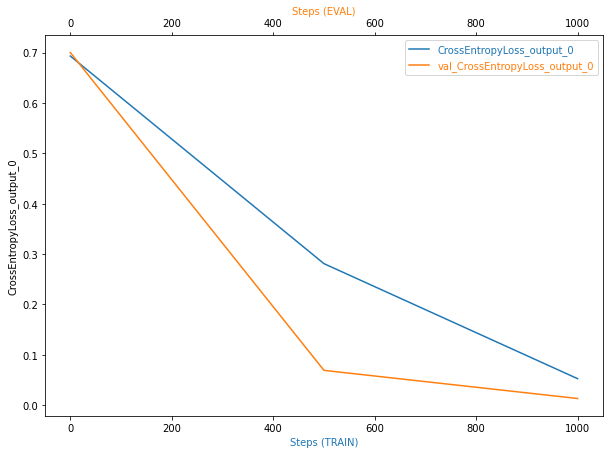

In [27]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

## Deployment

In [ ]:
# predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge")

INFO:sagemaker:Creating model with name: cola-distilbert-model-2023-09-30-16-06-36-688
INFO:sagemaker:Creating endpoint-config with name cola-distilbert-model-2023-09-30-16-06-36-688
INFO:sagemaker:Creating endpoint with name cola-distilbert-model-2023-09-30-16-06-36-688


-----------

In [39]:
# predictor